# TODO Notebook under construction

# Calculation of the loss function for classification


**Goal:** In this notebook you will calculate the loss function using numpy.


**Usage:** Execute the notebook until you reach the position your code here and fill out the blanks. 

**Dataset:** You work with the MNIST dataset. We have 60'000 28x28 pixel greyscale images of digits and want to classify them into the right label (0-9).

**Content:**
* load the original MNIST data 
* Eval the loss function using Keras 
* Implement the loss function yourself using numpy


| [open in colab](https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_04/nb_ch04_03.ipynb)



In [0]:
#load required libraries:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')
import numpy as np

import tensorflow as tf

import keras 
from keras.models import Sequential
from keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation
from keras import optimizers

Using TensorFlow backend.


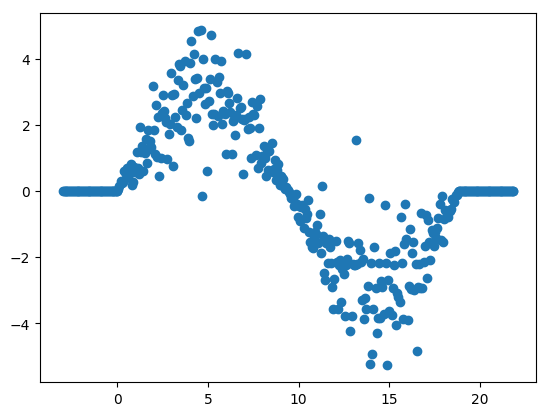

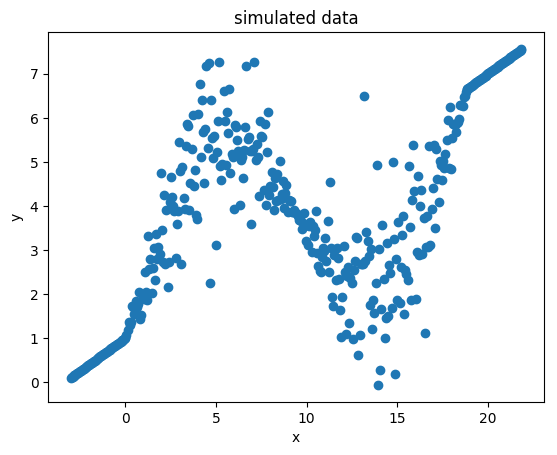

In [0]:
## Simulate some data 
n = 300
np.random.seed(42)
x = np.linspace(0,1*2*np.pi,n)
y1 = 3*np.sin(x)
y1 = np.concatenate((np.zeros(60), y1+np.random.normal(0,0.4*np.abs(y1),n),np.zeros(60)))
x=np.concatenate((np.linspace(-3,0,60),np.linspace(0,3*2*np.pi,n),np.linspace(3*2*np.pi,3*2*np.pi+3,60)))
plt.scatter(x=x,y=y1)
plt.show()
y2 = 0.3*x+1
y=y1+y2
plt.scatter(x=x,y=y)
plt.title("simulated data")
plt.xlabel("x")
plt.ylabel("y")
n=len(x)

In [0]:
model = Sequential()
model.add(Dense(1, activation='linear',batch_input_shape=(None, 1)))
model.compile(loss='mean_squared_error',optimizer="adam")

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [0]:

# train the model# train  
history=model.fit(x, y, 
                  batch_size=n, 
                  epochs=5000,
                  verbose=0, 
                 )

In [0]:
model.evaluate(x,y)

420/420 [==============================] - 0s 129us/step


2.876527279899234

Text(0, 0.5, 'y')

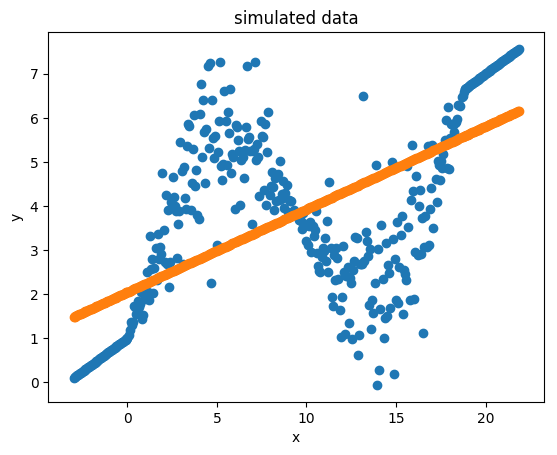

In [0]:
plt.scatter(x=x,y=y)
plt.scatter(x=x,y=model.predict(x))

plt.title("simulated data")
plt.xlabel("x")
plt.ylabel("y")

In [0]:
model.get_weights()

[array([[0.18793835]], dtype=float32), array([2.048634], dtype=float32)]

In [0]:
model = Sequential()
model.add(Dense(50, activation='relu',batch_input_shape=(None, 1)))
model.add(Dense(100, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='linear'))
#
model.compile(loss='mean_squared_error',optimizer="adam")


In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 50)                100       
_________________________________________________________________
dense_8 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_9 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 21        
Total params: 7,241
Trainable params: 7,241
Non-trainable params: 0
_________________________________________________________________


In [0]:
# train the model
history=model.fit(x, y, 
                  batch_size=n, 
                  epochs=5000,
                  verbose=0, 
                 )

In [0]:
model.evaluate(x,y)

420/420 [==============================] - 0s 221us/step


0.4973142372643841

Text(0, 0.5, 'y')

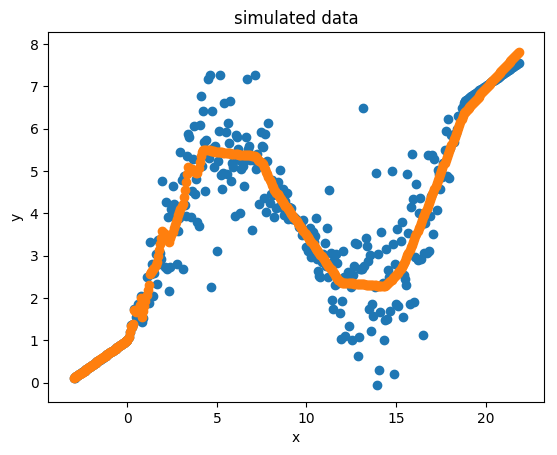

In [0]:
plt.scatter(x=x,y=y)
plt.scatter(x=x,y=model.predict(x))

plt.title("simulated data")
plt.xlabel("x")
plt.ylabel("y")

In [0]:
W=model.get_weights()
W[0]

array([[-2.24213339e-02,  2.14991465e-01, -7.10498318e-02,
        -2.98642784e-01,  1.58098161e-01, -1.99857101e-01,
        -1.88496619e-01, -3.08979392e-01, -5.39775714e-02,
         3.02214384e-01,  5.06950915e-02,  1.23602331e-01,
        -8.77229031e-04,  3.32985342e-01, -6.22690469e-02,
        -3.65366950e-03, -1.09003991e-01, -1.55076817e-01,
         2.09606275e-01,  2.55228877e-01,  1.92280546e-01,
        -7.17860013e-02, -2.56645590e-01,  1.08282544e-01,
        -3.06978941e-01, -2.04689102e-03, -6.73674867e-02,
        -2.90053040e-01, -8.41665920e-03, -3.16867262e-01,
        -2.00601056e-01, -7.26265013e-02, -2.43550986e-02,
        -1.97180986e-01,  3.02588761e-01,  3.47914308e-01,
        -3.00761849e-01, -6.73461780e-02, -2.36415919e-02,
         1.24808304e-01, -2.03812525e-01, -2.29036525e-01,
        -2.20239788e-01, -3.25805071e-04, -7.53126740e-02,
        -3.56971413e-01, -5.35782352e-02,  2.60096371e-01,
         1.31470144e-01, -1.09986633e-01]], dtype=float3

In [0]:
tf.reset_default_graph() #Just to be sure to start with an empty graph

X = tf.placeholder('float32', shape=[None,1], name='x_data')
Y = tf.placeholder('float32', shape=[None,1], name='y_data')

#W1 = tf.layers.dense(inputs=X,units=50,kernel_initializer= tf.constant_initializer(W[0]) ,bias_initializer=tf.Variable(initial_value=W[1]),activation='relu', name ='W1') 
W1 = tf.layers.dense(inputs=X,units=50,activation='relu', name ='W1') 
W2 = tf.layers.dense(inputs=W1,units=100,activation='relu', name ='W2') 
W3 = tf.layers.dense(inputs=W2,units=20,activation='relu', name ='W3') 

mu = tf.layers.dense(inputs=W3,units=1,activation='linear', name ='mu') 
log_sigma = tf.layers.dense(inputs=W3,units=1,activation='linear', name= 'log_sigma') 

a=1/(tf.sqrt(2*3.141*tf.square(tf.exp(log_sigma))))# 
b1=tf.square(mu-Y)
b2=2*tf.square(tf.exp(log_sigma))
b=b1/b2

loss = tf.reduce_sum(-tf.log(a)+b,axis=0)

#train_op = tf.train.GradientDescentOptimizer(0.00001).minimize(loss)
train_op = tf.train.AdamOptimizer(0.00003).minimize(loss)

init_op = tf.global_variables_initializer() 


Instructions for updating:
Use keras.layers.dense instead.


In [0]:
x=x.reshape(n,1)
y=y.reshape(n,1)

In [0]:
with tf.Session() as sess:
    sess.run(init_op) #Doing the initialization on the concrete realization of the graph
    loss_= sess.run(fetches=(loss), feed_dict={X:x, Y:y})
    print(loss_)

[2880.2246]


In [0]:
with tf.Session() as sess:
    sess.run(init_op) #Doing the initialization on the concrete realization of the graph
    for i in range(200000):
        #rand_index = np.random.choice(n, size=32)
        #x_batch = x[rand_index]
        #y_batch = y[rand_index]
        #loss_,_, = sess.run(fetches=(loss,train_op), feed_dict={X:x_batch, Y:y_batch})
        loss_,_,pred_mu,pred_log_sigma = sess.run(fetches=(loss,train_op,mu,log_sigma), feed_dict={X:x, Y:y})
        if (i % 20000 == 0):
            print("i={} loss={}".format(i,loss_))        
    #loss_,_,pred_mu,pred_log_sigma = sess.run(fetches=(loss,train_op,mu,log_sigma), feed_dict={X:x, Y:y})
    print("i={} loss={}".format(i,loss_))

i=0 loss=[3192.3784]
i=20000 loss=[-69.94945]
i=40000 loss=[-337.23492]
i=60000 loss=[615.59314]
i=80000 loss=[-398.29572]
i=100000 loss=[-215.79413]
i=120000 loss=[-366.44617]
i=140000 loss=[-438.9627]
i=160000 loss=[-445.9432]
i=180000 loss=[-452.87015]
i=199999 loss=[-456.70856]


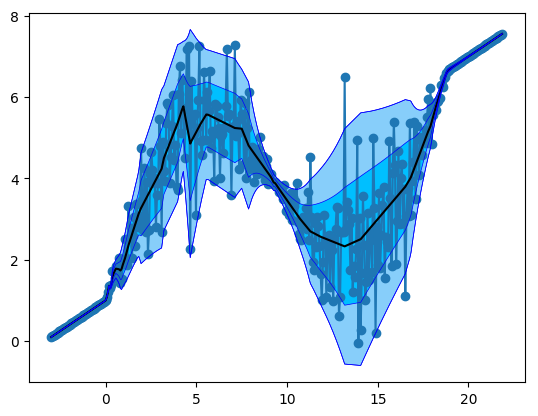

In [0]:
plt.plot(x,y[:,0],marker='o')

plt.plot(x,pred_mu[:,0],c="black")

pred_1_sd_p = pred_mu[:,0]+(np.exp(pred_log_sigma[:,0]))
pred_1_sd_m = pred_mu[:,0]-(np.exp(pred_log_sigma[:,0]))

plt.plot(x,pred_1_sd_p, 'b', linewidth=0.5)
plt.plot(x,pred_1_sd_m, 'b', linewidth=0.5)

pred_2_sd_p = pred_mu[:,0]+2*(np.exp(pred_log_sigma[:,0]))
pred_2_sd_m = pred_mu[:,0]-2*(np.exp(pred_log_sigma[:,0]))

plt.plot(x,pred_2_sd_p, 'b', linewidth=0.5)
plt.plot(x,pred_2_sd_m, 'b', linewidth=0.5)


plt.plot(x,pred_mu[:,0]+2*(np.exp(pred_log_sigma[:,0])), 'b', linewidth=0.5)
plt.plot(x,pred_mu[:,0]-2*(np.exp(pred_log_sigma[:,0])), 'b', linewidth=0.5)

plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([pred_2_sd_p,
                         pred_2_sd_m[::-1]]),alpha=1, fc='lightskyblue', ec='None')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([pred_1_sd_p,
                         pred_1_sd_m[::-1]]),alpha=1, fc='deepskyblue', ec='None')
plt.show()
